In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import theano
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dense, Dropout
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [3]:
sg_df = pd.read_csv('D:/data/quicken_loans_sg.csv')
sg_df.rename(columns = {'shot_dist_x': 'shot_dist', 'shot_dist_y': 'hole_dist_yds'}, inplace = True)
sg_df

,player_id,player_name,date_started,tournament_id,course_num,year,round_num,hole_num,hole_id,par,stroke_num,stroke_gained,shot_loc,shot_dist,hole_dist_yds
0,25632.0,Jimmy Walker,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,1.0,0.160,Tee,13680.0,380.0
1,25632.0,Jimmy Walker,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,2.0,0.063,Fairway,3810.0,380.0
2,25632.0,Jimmy Walker,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,3.0,-0.272,Green,156.0,380.0
3,25632.0,Jimmy Walker,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,4.0,0.009,Green,25.0,380.0
4,29476.0,Kyle Reifers,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,1.0,0.160,Tee,13680.0,380.0
5,29476.0,Kyle Reifers,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,2.0,-0.063,Fairway,3317.0,380.0
6,29476.0,Kyle Reifers,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,3.0,-0.190,Green,227.0,380.0
7,29476.0,Kyle Reifers,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,4.0,0.053,Green,39.0,380.0
8,30110.0,Kyle Stanley,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,1.0,0.160,Tee,13680.0,380.0
9,30110.0,Kyle Stanley,03_31_2016,20.0,729.0,2016.0,1.0,10.0,2016_020_729_1_10,4.0,2.0,-0.170,Fairway,3509.0,380.0


In [4]:
player_ls = sg_df['player_name'].unique()

grouped_df = sg_df[['player_id', 'player_name', 'date_started', 'tournament_id', 'course_num', 'hole_num',
                    'hole_id','round_num', 'stroke_gained', 'par','hole_dist_yds']].groupby(['player_id', 
                    'player_name','date_started', 'hole_id', 'tournament_id', 'course_num', 'round_num', 
                    'hole_num', 'par', 'hole_dist_yds']).sum()

grouped_df.reset_index(inplace = True)

In [5]:
now = datetime.now()

def create_datetime(x):
    date = datetime.strptime(x, '%m_%d_%Y')
    return date

def days_elapsed(date):
    return (now - date).days

grouped_df['date_started'] = grouped_df['date_started'].apply(lambda x: create_datetime(x))
grouped_df['days_elapsed'] = grouped_df['date_started'].apply(lambda x: days_elapsed(x))
grouped_df

,player_id,player_name,date_started,hole_id,tournament_id,course_num,round_num,hole_num,par,hole_dist_yds,stroke_gained,days_elapsed
0,19846.0,Brian Gay,2017-01-12,2017_006_6_1_1,6.0,6.0,1.0,1.0,4.0,480.000000,0.28,166
1,19846.0,Brian Gay,2017-01-12,2017_006_6_1_10,6.0,6.0,1.0,10.0,4.0,351.000000,-0.08,166
2,19846.0,Brian Gay,2017-01-12,2017_006_6_1_11,6.0,6.0,1.0,11.0,3.0,194.000000,0.12,166
3,19846.0,Brian Gay,2017-01-12,2017_006_6_1_12,6.0,6.0,1.0,12.0,4.0,440.000000,0.08,166
4,19846.0,Brian Gay,2017-01-12,2017_006_6_1_13,6.0,6.0,1.0,13.0,4.0,477.000000,0.28,166
5,19846.0,Brian Gay,2017-01-12,2017_006_6_1_14,6.0,6.0,1.0,14.0,4.0,430.000000,0.08,166
6,19846.0,Brian Gay,2017-01-12,2017_006_6_1_15,6.0,6.0,1.0,15.0,4.0,398.000000,-0.01,166
7,19846.0,Brian Gay,2017-01-12,2017_006_6_1_16,6.0,6.0,1.0,16.0,4.0,417.000000,0.02,166
8,19846.0,Brian Gay,2017-01-12,2017_006_6_1_17,6.0,6.0,1.0,17.0,3.0,194.000000,0.12,166
9,19846.0,Brian Gay,2017-01-12,2017_006_6_1_18,6.0,6.0,1.0,18.0,5.0,551.000000,-0.26,166


C:\Users\vales\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\vales\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Train on 3676 samples, validate on 194 samples
Epoch 1/75
3676/3676 [==============================] - 15s - loss: 0.0743 - val_loss: 0.0551
Epoch 2/75
3676/3676 [==============================] - 10s - loss: 0.0197 - val_loss: 0.0075
Epoch 3/75
3676/3676 [==============================] - 9s - loss: 0.0130 - val_loss: 0.0726
Epoch 4/75
3676/3676 [==============================] - 9s - loss: 0.0104 - val_loss: 0.0027
Epoch 5/75
3676/3676 [==============================] - 9s - loss: 0.0085 - val_loss: 0.0281
Epoch 6/75
3676/3676 [==============================] - 10s - loss: 0.0069 - val_loss: 1.7003e-04
Epoch 7/75
3676/3676 [==============================] - 9s - loss: 0.0059 - val_loss: 0.0089
Epoch 8/75
3676/3676 [==============================] - 9s - loss: 0.0050 - val_loss: 2.8146e-04
Epoch 9/75
3676/3676 [==============================] - 9s - loss: 0.0043 - val_loss: 0.0251
Epoch 10/75
3676/3676 [==============================] - 9s - loss: 0.0045 - val_loss: 0.0010
Epoch 11/75

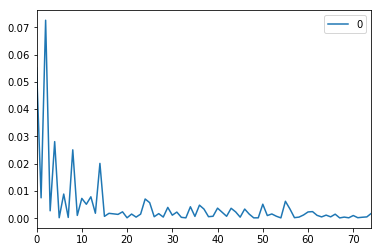

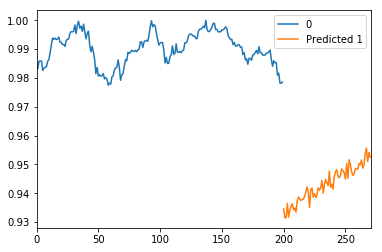

In [109]:
def create_df(player):
    df = grouped_df[grouped_df['player_name'] == player]
    
    df.sort_values(['date_started', 'round_num', 'hole_num'], inplace = True)
    df.reset_index(inplace = True, drop = True)
    
    df['cum_sum'] = df['stroke_gained'].cumsum()
    
    num_cols = ['cum_sum', 'days_elapsed']#'tournament_id', 'course_num', 'round_num', 'hole_num',
             #'par', 'hole_dist_yds', 'days_elapsed']

    input_df = df[num_cols]
    
    scaler = MinMaxScaler(feature_range = (0,1))
    input_df = pd.DataFrame(scaler.fit_transform(input_df), columns = num_cols)
    
    final_df = pd.concat([df['cum_sum'], input_df], axis = 1)
    
    return input_df

def run_rnn(df):
    data = df.values

    examples = 72 # how far to look back
    y_examples = 72 # how far to predict in the future
    nb_samples = len(data) - examples - y_examples

    input_list = [np.expand_dims(np.atleast_2d(data[i:examples+i,:]), axis=0) for i in range(nb_samples)]
    input_mat = np.concatenate(input_list, axis=0)

    # use the tail of the series as the test data
    df_test = pd.DataFrame(df[-examples:])

    test_data = df_test.values
    test_input_list = [np.expand_dims(np.atleast_2d(test_data[len(test_data)-examples:len(test_data),:]), axis=0) for i in range(1)]
    test_input_mat = np.concatenate(test_input_list, axis=0)

    # target - the first column in df dataframe
    target_list = [np.atleast_2d(data[i+examples:examples+i+y_examples,0]) for i in range(nb_samples)]
    target_mat = np.concatenate(target_list, axis=0)

    #Set up model
    features = input_mat.shape[2]
    hidden = 128
    epochs = 75
    batch_size = 100
    validation_split = 0.05

    model = Sequential()
    model.add(LSTM(hidden, input_shape = (examples, features), return_sequences = True))
    model.add(Dropout(.2))
    model.add(LSTM(hidden, return_sequences = False))
    model.add(Dropout(.2))
    model.add(Dense(y_examples))
    model.add(Activation('linear'))
    model.compile(loss = 'mse', optimizer = 'rmsprop')

    #Train
    hist = model.fit(input_mat, target_mat, epochs = epochs, batch_size = batch_size, 
                     validation_split = validation_split, verbose = 1)

    predicted = model.predict(test_input_mat)

    df_val_loss = pd.DataFrame(hist.history['val_loss'])
    df_val_loss.plot()

    df_predicted = pd.DataFrame(predicted).T
    df_predicted.columns = ['Predicted 1']

    df_result = pd.concat([df['cum_sum'][-200:], df_predicted], ignore_index = True)
    df_result.plot()

    plt.show()
    
    return df_result

for player in player_ls[:1]:
    df = create_df(player)
    df_result = run_rnn(df)

In [100]:
player = player_ls[2]

df = create_df(player)
data = df.values

examples = 360 # how far to look back
y_examples = 72 # how far to predict in the future
nb_samples = len(data) - examples - y_examples

input_list = [np.expand_dims(np.atleast_2d(data[i:examples+i,:]), axis=0) for i in range(nb_samples)]
input_mat = np.concatenate(input_list, axis=0)

# use the tail of the series as the test data
df_test = pd.DataFrame(df[-examples:])

test_data = df_test.values
test_input_list = [np.expand_dims(np.atleast_2d(test_data[len(test_data)-examples:len(test_data),:]), axis=0) for i in range(1)]
test_input_mat = np.concatenate(test_input_list, axis=0)

# target - the first column in df dataframe
target_list = [np.atleast_2d(data[i+examples:examples+i+y_examples,0]) for i in range(nb_samples)]
target_mat = np.concatenate(target_list, axis=0)

#Set up model
features = input_mat.shape[2]
hidden = 128
epochs = 8
batch_size = 250
validation_split = 0.15

model = Sequential()
model.add(LSTM(hidden, input_shape = (examples, features)))
model.add(Dropout(.2))
model.add(Dense(y_examples))
model.add(Activation('linear'))
model.compile(loss = 'mse', optimizer = 'rmsprop')


#Train
hist = model.fit(input_mat, target_mat, epochs = epochs, batch_size = batch_size, 
                 validation_split = validation_split, verbose = 1)

predicted = model.predict(test_input_mat)

df_val_loss = pd.DataFrame(hist.history['val_loss'])
df_val_loss.plot()

df_predicted = pd.DataFrame(predicted).T
df_predicted.columns = ['Predicted 1']

df_result = pd.concat([df['cum_sum'][-200:], df_predicted], ignore_index = True)
df_result.plot()

plt.show()

C:\Users\vales\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\vales\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Train on 3258 samples, validate on 576 samples
Epoch 1/8
 750/3258 [=====>........................] - ETA: 53s - loss: 0.1665

KeyboardInterrupt: 

In [66]:
df

,cum_sum,days_elapsed
0,0.214019,1.000000
1,0.209980,1.000000
2,0.210446,1.000000
3,0.203766,1.000000
4,0.204427,1.000000
5,0.207300,1.000000
6,0.207961,1.000000
7,0.208155,1.000000
8,0.203805,1.000000
9,0.207766,1.000000


In [32]:
np.asarray(test_input_list).shape, np.asarray(test_input_mat).shape, np.asarray(target_list).shape, np.asarray(target_mat).shape

((1, 1, 288, 8), (1, 288, 8), (3654, 1, 72), (3654, 72))

In [70]:
np.random.seed(7)
dataset = df['cum_sum'].values
dataset = dataset.astype('float32').reshape(-1,1)

mm_scaler =  MinMaxScaler(feature_range = (0,1))
dataset = mm_scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[:train_size, :], dataset[train_size: len(dataset), :]
print(len(train), len(test))

2858 1408


In [72]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i: (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [75]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [77]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10000, verbose=1)

Epoch 1/100
2856/2856 [==============================] - 1s - loss: 0.0900
Epoch 2/100
2856/2856 [==============================] - 0s - loss: 0.0894
Epoch 3/100
2856/2856 [==============================] - 0s - loss: 0.0886
Epoch 4/100
2856/2856 [==============================] - 0s - loss: 0.0879
Epoch 5/100
2856/2856 [==============================] - 0s - loss: 0.0871
Epoch 6/100
2856/2856 [==============================] - 0s - loss: 0.0862
Epoch 7/100
2856/2856 [==============================] - 0s - loss: 0.0854
Epoch 8/100
2856/2856 [==============================] - 0s - loss: 0.0846
Epoch 9/100
2856/2856 [==============================] - 0s - loss: 0.0838
Epoch 10/100
2856/2856 [==============================] - 0s - loss: 0.0830
Epoch 11/100
2856/2856 [==============================] - 0s - loss: 0.0822
Epoch 12/100
2856/2856 [==============================] - 0s - loss: 0.0813
Epoch 13/100
2856/2856 [==============================] - 0s - loss: 0.0805
Epoch 14/100
2856/285

In [83]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = mm_scaler.inverse_transform(trainPredict)
trainY = mm_scaler.inverse_transform(trainY)
testPredict = mm_scaler.inverse_transform(testPredict)
testY = mm_scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.18 RMSE
Test Score: 0.57 RMSE


C:\Users\vales\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Epoch 1/100
2569/2569 [==============================] - 2s - loss: 0.0327
Epoch 2/100
2569/2569 [==============================] - 0s - loss: 0.0170
Epoch 3/100
2569/2569 [==============================] - 0s - loss: 0.0058
Epoch 4/100
2569/2569 [==============================] - 0s - loss: 0.0012
Epoch 5/100
2569/2569 [==============================] - 0s - loss: 0.0024
Epoch 6/100
2569/2569 [==============================] - 0s - loss: 0.0061
Epoch 7/100
2569/2569 [==============================] - 0s - loss: 0.0086
Epoch 8/100
2569/2569 [==============================] - 0s - loss: 0.0086
Epoch 9/100
2569/2569 [==============================] - 0s - loss: 0.0069
Epoch 10/100
2569/2569 [==============================] - 0s - loss: 0.0047
Epoch 11/100
2569/2569 [==============================] - 0s - loss: 0.0028
Epoch 12/100
2569/2569 [==============================] - 0s - loss: 0.0017
Epoch 13/100
2569/2569 [==============================] - 0s - loss: 0.0014
Epoch 14/100
2569/256

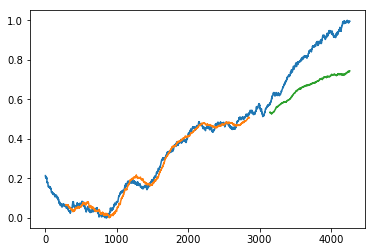

In [94]:
import numpy
dataset = df['cum_sum'].reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 288
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10000, verbose=1)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [112]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from random import random
import pandas as pd

In [111]:
in_out_neurons = 2
hidden_neurons = 300

model = Sequential()
model.add(LSTM(hidden_neurons, return_sequences=False,
               input_shape=(None, in_out_neurons)))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [116]:
flow = (list(range(1,10,1)) + list(range(10,1,-1)))*1000  
pdata = pd.DataFrame({"a":flow, "b":flow})  
pdata.b = pdata.b.shift(9)  
data = pdata.iloc[10:] * random()  # some noise

def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = train_test_split(data)  # retrieve data

# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=450, epochs=10, validation_split=0.05)

Train on 15286 samples, validate on 805 samples
Epoch 1/10
15286/15286 [==============================] - 70s - loss: 0.0061 - val_loss: 2.4998e-04
Epoch 2/10
15286/15286 [==============================] - 58s - loss: 7.2655e-04 - val_loss: 8.7122e-04
Epoch 3/10
15286/15286 [==============================] - 56s - loss: 7.0106e-04 - val_loss: 0.0012
Epoch 4/10
15286/15286 [==============================] - 48s - loss: 5.3368e-04 - val_loss: 7.1241e-04
Epoch 5/10
 7200/15286 [=============>................] - ETA: 27s - loss: 5.1655e-04

ResourceExhaustedError: OOM when allocating tensor with shape[450,100,300]
	 [[Node: gradients_37/lstm_49/concat_1_grad/Slice_2 = Slice[Index=DT_INT32, T=DT_FLOAT, _class=["loc:@lstm_49/concat_1"], _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_37/lstm_49/transpose_grad/transpose, gradients_37/lstm_49/concat_1_grad/ConcatOffset:2, gradients_37/lstm_49/concat_1_grad/ShapeN:2)]]

Caused by op 'gradients_37/lstm_49/concat_1_grad/Slice_2', defined at:
  File "C:\Users\vales\Anaconda3\lib\runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\vales\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\vales\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\vales\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\vales\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\vales\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\vales\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\vales\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\vales\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\vales\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\vales\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\vales\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\vales\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\vales\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\vales\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\vales\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\vales\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2793, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\vales\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-116-436c7f2881be>", line 36, in <module>
    model.fit(X_train, y_train, batch_size=450, epochs=10, validation_split=0.05)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\models.py", line 856, in fit
    initial_epoch=initial_epoch)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\engine\training.py", line 1481, in fit
    self._make_train_function()
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\engine\training.py", line 1013, in _make_train_function
    self.total_loss)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\optimizers.py", line 197, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\optimizers.py", line 47, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2264, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 560, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 368, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 560, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\array_grad.py", line 194, in _ConcatGradV2
    op, grad, start_value_index=0, end_value_index=-1, dim_index=-1)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\array_grad.py", line 126, in _ConcatGradHelper
    out_grads.append(array_ops.slice(grad, begin, size))
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 545, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2933, in _slice
    name=name)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'lstm_49/concat_1', defined at:
  File "C:\Users\vales\Anaconda3\lib\runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
[elided 16 identical lines from previous traceback]
  File "C:\Users\vales\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\vales\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\vales\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-111-d6b7e7e9a507>", line 6, in <module>
    input_shape=(None, in_out_neurons)))
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\models.py", line 433, in add
    layer(x)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 243, in __call__
    return super(Recurrent, self).__call__(inputs, **kwargs)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\engine\topology.py", line 585, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 312, in call
    preprocessed_input = self.preprocess_input(inputs, training=None)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 1056, in preprocess_input
    return K.concatenate([x_i, x_f, x_c, x_o], axis=2)
  File "C:\Users\vales\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1681, in concatenate
    return tf.concat([to_dense(x) for x in tensors], axis)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1034, in concat
    name=name)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 519, in _concat_v2
    name=name)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\vales\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[450,100,300]
	 [[Node: gradients_37/lstm_49/concat_1_grad/Slice_2 = Slice[Index=DT_INT32, T=DT_FLOAT, _class=["loc:@lstm_49/concat_1"], _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_37/lstm_49/transpose_grad/transpose, gradients_37/lstm_49/concat_1_grad/ConcatOffset:2, gradients_37/lstm_49/concat_1_grad/ShapeN:2)]]


In [ ]:
predicted = model.predict(X_test)  
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (17, 9)
plt.plot(predicted[:100][:,0],"--")
plt.plot(predicted[:100][:,1],"--")
plt.plot(y_test[:100][:,0],":")
plt.plot(y_test[:100][:,1],":")
plt.legend(["Prediction 0", "Prediction 1", "Test 0", "Test 1"])